<a href="https://colab.research.google.com/github/visahan1/Tensorflow/blob/main/BERT_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fine-Tune BERT for Text Classification with TensorFlow

In [38]:
import tensorflow as tf
print(tf.version.VERSION)

2.5.0


In [39]:
!pip install -q tensorflow==2.3.0

In [40]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

fatal: destination path 'models' already exists and is not an empty directory.


In [41]:
!pip install -Uqr models/official/requirements.txt
# install requirements to use tensorflow/models repository

ERROR: tensorflow 2.3.0 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.21.0 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement scipy==1.4.1, but you'll have scipy 1.7.0 which is incompatible.
ERROR: pandas-gbq 0.13.3 has requirement google-cloud-bigquery[bqstorage,pandas]<2.0.0dev,>=1.11.1, but you'll have google-cloud-bigquery 2.20.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement pandas~=1.1.0; python_version >= "3.0", but you'll have pandas 1.3.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement six~=1.15.0, but you'll have six 1.16.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [42]:
!nvidia-smi

Fri Jul  2 17:33:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    32W /  70W |    740MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

|A downloadable copy of the [Quora Insincere Questions Classification data](https://www.kaggle.com/c/quora-insincere-questions-classification/data) can be found [https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip](https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip). Decompress and read the data into a pandas DataFrame.

In [43]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization


In [44]:
from sklearn.model_selection import train_test_split

In [45]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.5.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


In [46]:
df = pd.read_csv('https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip',
            compression='zip',low_memory=False)

In [47]:
df.shape

(1306122, 3)

In [48]:
df.head(10)

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0
5,00004f9a462a357c33be,"Is Gaza slowly becoming Auschwitz, Dachau or T...",0
6,00005059a06ee19e11ad,Why does Quora automatically ban conservative ...,0
7,0000559f875832745e2e,Is it crazy if I wash or wipe my groceries off...,0
8,00005bd3426b2d0c8305,"Is there such a thing as dressing moderately, ...",0
9,00006e6928c5df60eacb,Is it just me or have you ever been in this ph...,0


<AxesSubplot:title={'center':'Target'}, ylabel='Frequency'>

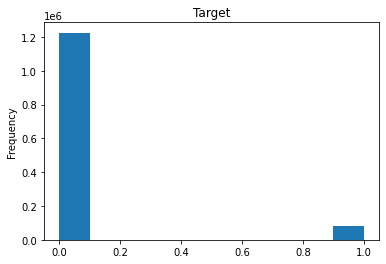

In [49]:
df.target.plot(kind='hist',title='Target')

Create tf.data.Datasets for Training and Evaluation.
The above is a highly imbalanced data set and thus we have to take stratified samples of data

In [50]:
#Using a fraction of data to train in Colab
train_df, remaining = train_test_split(df,random_state=42,train_size=0.0075,stratify=df.target.values)
valid_df , _ = train_test_split(remaining,random_state=42,train_size=0.00075,stratify=remaining.target.values)

In [51]:
print('Train shape {}, Test Shape {} '.format(train_df.shape,valid_df.shape))

Train shape (9795, 3), Test Shape (972, 3) 


In [80]:
#The data preprocessing to be done in CPU to avoid GPU overhead
# TF data returns iterable python object
with tf.device('/cpu:0'):
  train_data = tf.data.Dataset.from_tensor_slices((train_df.question_text.values,train_df.target.values))
  valid_data = tf.data.Dataset.from_tensor_slices((valid_df.question_text.values,valid_df.target.values))

In [53]:
for text,label in train_data.take(1):
  print(text)
  print(label)

tf.Tensor(b'Why are unhealthy relationships so desirable?', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


In [54]:
label_list = [0,1]
max_seq_length = 128 #BERT supports upto 512
train_batch_size = 32


In [70]:
bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2',trainable=True)

In [71]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()

In [72]:
#To check we are using uncased version of the BERT
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

In [73]:
do_lower_case

True

In [74]:
#Runs end-to-end tokenziation.
tokenizer = tokenization.FullTokenizer(vocab_file,do_lower_case=do_lower_case)

In [75]:
tokenizer.wordpiece_tokenizer.tokenize('hi, how are you doing?')

['hi', '##,', 'how', 'are', 'you', 'doing', '##?']

In [76]:
tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize('hi, how are you doing?'))

[7632, 29623, 2129, 2024, 2017, 2725, 29632]

In [77]:
# This provides a function to convert row to input features and label
#text_b is None as we are doing Classification not Next Senetnce Prediction
def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  example = classifier_data_lib.InputExample(guid=None,
                                 text_a=text.numpy(),
                                 text_b=None,
                                 label=label.numpy())
 #Convert Example in to feature
  feature = classifier_data_lib.convert_single_example(0,example=example,label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer)
  return (feature.input_ids,feature.input_mask,feature.segment_ids,feature.label_id)

You want to use [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) to apply this function to each element of the dataset. [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) runs in graph mode.

- Graph tensors do not have a value.
- In graph mode you can only use TensorFlow Ops and functions.

So you can't `.map` this function directly: You need to wrap it in a [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function). The [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function) will pass regular tensors (with a value and a `.numpy()` method to access it), to the wrapped python function.

Wrap a Python Function into a TensorFlow op for Eager Execution

In [78]:
def to_feature_map(text, label):
  input_ids,input_mask,segment_ids,label_id=tf.py_function(to_feature,inp=[text, label],
                                                           Tout=[tf.int32,tf.int32,tf.int32,tf.int32])
  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([])
  x= {
      'input_word_ids':input_ids,
      'input_mask':input_mask,
      'input_type_ids':segment_ids
  }
  return x,label_id

## Task 8: Create a TensorFlow Input Pipeline with `tf.data`

In [81]:
with tf.device('/cpu:0'):
  # train
  train_data = (train_data.map(to_feature_map,
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
  .shuffle(1024)
  .batch(train_batch_size,drop_remainder=True)
  .prefetch(tf.data.AUTOTUNE))

  # valid
  valid_data = (valid_data.map(to_feature_map,num_parallel_calls=tf.data.experimental.AUTOTUNE)
  .batch(train_batch_size,drop_remainder=True)
  .prefetch(tf.data.AUTOTUNE))
  

In [83]:
# train data spec
train_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [82]:
# valid data spec
valid_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [86]:
# Building the model
def create_model():
    input_word_ids=tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32)
    input_mask=tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32)
    input_type_ids=tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32)
    pooled_output,sequence_output = bert_layer([input_word_ids,input_mask,input_type_ids])
    #As its a classification problem we can ignore sequence_output
    x = tf.keras.layers.Dropout(0.4)(pooled_output)
    out = tf.keras.layers.Dense(1,activation='sigmoid')(x)
    model = tf.keras.Model(inputs = {
       'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': input_type_ids
    },
    outputs = out)
    return model

In [90]:
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
                                                 loss=tf.keras.losses.BinaryCrossentropy(),
                                                 metrics=[tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_23 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_24 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer_3 (KerasLayer)      [(None, 768), (None, 109482241   input_22[0][0]                   
                                                                 input_23[0][0]             

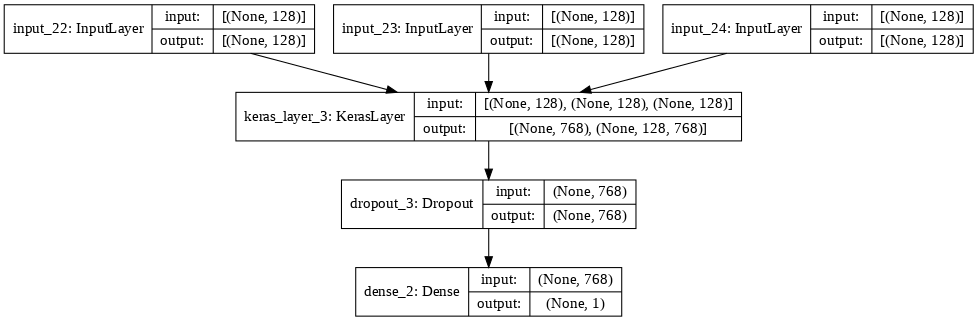

In [91]:
tf.keras.utils.plot_model(model=model,show_shapes=True,dpi=76)

In [94]:
#Finetune the model
epochs = 2
history = model.fit(train_data,validation_data=valid_data,epochs=epochs,verbose=1)


Epoch 1/2
306/306 [==============================] - ETA: 0s - loss: 0.1284 - binary_accuracy: 0.9508WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f95f41be830> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
306/306 [==============================] - 261s 850ms/step - loss: 0.1284 - binary_accuracy: 0.9508 - val_loss: 0.1184 - val_binary_accuracy: 0.9615
Epoch 2/2
306/306 [==============================] - 260s 846ms/step - loss: 0.0768 - binary_accuracy: 0.9714 - val_loss: 0.1446 - val_binary_accuracy: 0.9510


In [95]:
 import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

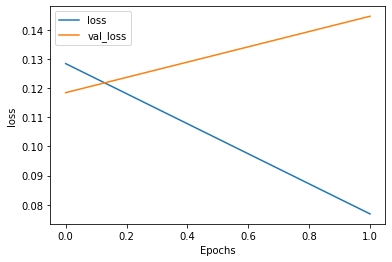

In [98]:
plot_graphs(history=history,metric='loss')

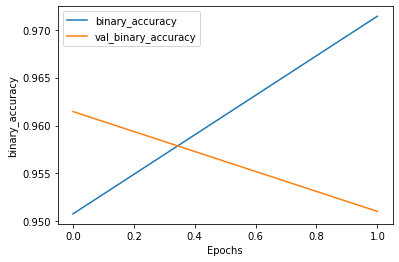

In [99]:
plot_graphs(history=history,metric='binary_accuracy')

In [117]:
test=["Is it crazy if I wash or wipe my groceries off" , "Go Corona go","Sincere1"]
#[0]*len(test)- Dummy labels
test_data = tf.data.Dataset.from_tensor_slices((test,[0]*len(test)))
test_data = test_data.map(to_feature_map).batch(1)
preds=model.predict(test_data)
thres= 0.5
print(preds)
#['Insincere' if preds > thres else 'Sincere' for pred in preds]

[[0.00275629]
 [0.02471643]
 [0.04596459]]
